In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import holidays

import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

# Data preprocessing

In [2]:
df =  pd.read_csv('2yrs_data.csv')

In [3]:
data = df.copy()
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
#data.set_index('Datetime', inplace=True)

# # Resample data to hourly frequency and compute the sum
# hourly_data = df['Global_active_power'].resample('H').sum().reset_index()
# hourly_data.rename(columns={'Global_active_power': 'Hourly_Sum'}, inplace=True)

# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(hourly_data['Hourly_Sum'].values.reshape(-1, 1))

df['Date'] = pd.to_datetime(df['Date'])
df['is_weekend'] = df['Date'].dt.weekday.isin([5, 6]).astype(int)

fr_holidays = holidays.France(years=range(2006, 2010))
df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)
df['Global_active_power'] = df['Global_active_power'].values.reshape(-1, 1)

scaler = StandardScaler()
df['Global_active_power'] = scaler.fit_transform(df[['Global_active_power']])


/var/folders/hb/pn_3c51d1fj1n2jntgjrxmpm0000gn/T/ipykernel_7842/3372390953.py:16: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)


In [4]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,is_holiday
0,2006-12-16,17:24:00,2.753579,0.418,234.84,18.4,0.0,1.0,17.0,1,0
1,2006-12-16,17:25:00,3.768106,0.436,233.63,23.0,0.0,1.0,16.0,1,0
2,2006-12-16,17:26:00,3.780522,0.498,233.29,23.0,0.0,2.0,17.0,1,0
3,2006-12-16,17:27:00,3.792937,0.502,233.74,23.0,0.0,1.0,17.0,1,0
4,2006-12-16,17:28:00,2.265825,0.528,235.68,15.8,0.0,1.0,17.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,-0.556052,0.064,247.69,2.2,0.0,0.0,0.0,0,0
1070562,2008-12-31,23:56:00,-0.557826,0.064,247.35,2.2,0.0,0.0,0.0,0,0
1070563,2008-12-31,23:57:00,-0.557826,0.064,246.99,2.2,0.0,0.0,0.0,0,0
1070564,2008-12-31,23:58:00,-0.559600,0.064,246.52,2.2,0.0,0.0,0.0,0,0


In [5]:
df['Global_active_power'].describe()

count    1.070566e+06
mean     1.533430e-16
std      1.000000e+00
min     -9.178769e-01
25%     -7.280964e-01
50%     -4.922009e-01
75%      3.875295e-01
max      8.477147e+00
Name: Global_active_power, dtype: float64

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(df['Global_active_power'], lags=10)
# plot_pacf(df['Global_active_power'], lags=10)

# Baseline

In [7]:
# Parameters
N_STEPS_IN = 2
N_STEPS_OUT = 5
N_EPOCHS = 20
BATCH_SIZE = 16

train_size = int(len(df) * 0.8)  # 80% for training
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Function to create sequences
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

# Prepare sequences for training
train_values = train['Global_active_power'].values  # Get values as a NumPy array
X_train, y_train = create_sequences(train_values, N_STEPS_IN, N_STEPS_OUT)

test_values = test['Global_active_power'].values
X_test, y_test = create_sequences(test_values, N_STEPS_IN, N_STEPS_OUT)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 1 feature
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (856446, 2, 1)
y_train shape: (856446, 5)
X_test shape: (214108, 2, 1)
y_test shape: (214108, 5)


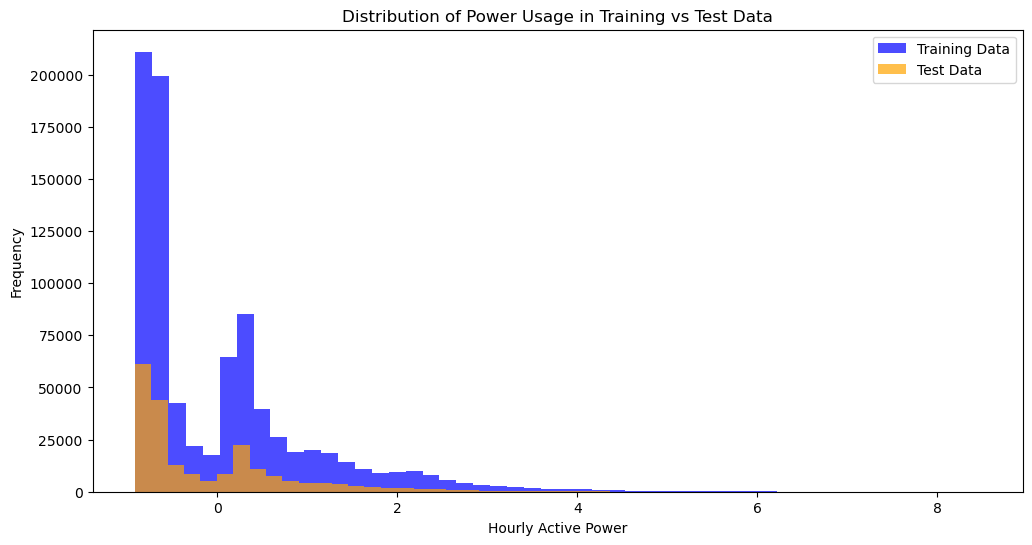

In [8]:
plt.figure(figsize=(12, 6))
plt.hist(train['Global_active_power'], bins=50, alpha=0.7, label='Training Data', color='blue')
plt.hist(test['Global_active_power'], bins=50, alpha=0.7, label='Test Data', color='orange')
plt.title('Distribution of Power Usage in Training vs Test Data')
plt.xlabel('Hourly Active Power')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, 1)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(N_STEPS_OUT)
])

# Compile model
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Remove validation references in callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    shuffle=False
)

# Predict on the test set
test_predictions = model.predict(X_test, verbose=0)

# Reshape predictions and labels for comparison
test_predictions = np.squeeze(test_predictions)  # Ensure 1D if necessary
y_test = np.squeeze(y_test)  # Ensure 1D if necessary

# Ensure the shapes are consistent
print(f"Shape of predictions: {test_predictions.shape}")
print(f"Shape of test labels: {y_test.shape}")

# Calculate metrics
test_mse = mean_squared_error(y_test, test_predictions)
mape = np.mean(np.abs((y_test - test_predictions) / (y_test + 1e-6))) * 100  # Avoid division-by-zero
r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

# Print metrics
print(f"Test MSE: {test_mse:.5f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.5f}")
print(f"Test RMSE: {test_rmse:.5f}")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53528/53528 ━━━━━━━━━━━━━━━━━━━━ 50s 924us/step - loss: 0.3525 - mae: 0.3093 - learning_rate: 1.0000e-04
Epoch 2/20
53528/53528 ━━━━━━━━━━━━━━━━━━━━ 51s 944us/step - loss: 0.2264 - mae: 0.2455 - learning_rate: 1.0000e-04
Epoch 3/20
53528/53528 ━━━━━━━━━━━━━━━━━━━━ 47s 887us/step - loss: 0.2304 - mae: 0.2539 - learning_rate: 1.0000e-04
Epoch 4/20
53528/53528 ━━━━━━━━━━━━━━━━━━━━ 45s 845us/step - loss: 0.2352 - mae: 0.2659 - learning_rate: 1.0000e-04
Epoch 5/20
53528/53528 ━━━━━━━━━━━━━━━━━━━━ 50s 930us/step - loss: 0.2293 - mae: 0.2655 - learning_rate: 1.0000e-04
Epoch 6/20
53528/53528 ━━━━━━━━━━━━━━━━━━━━ 51s 956us/step - loss: 0.2286 - mae: 0.2711 - learning_rate: 1.0000e-04
Epoch 7/20
53528/53528 ━━━━━━━━━━━━━━━━━━━━ 51s 955us/step - loss: 0.2402 - mae: 0.2844 - learning_rate: 1.0000e-04
Epoch 8/20
53528/53528 ━━━━━━━━━━━━━━━━━━━━ 53s 991us/step - loss: 0.2570 - mae: 0.3009 - learning_rate: 1.0000e-04
Epoch 9/20
53528/53528 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 0.2595 - mae: 0.30

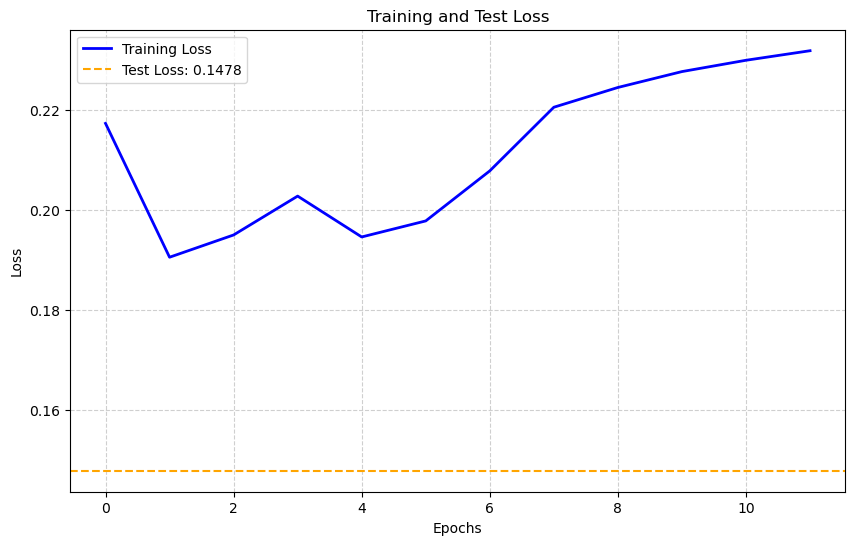

In [10]:
loss = history.history['loss']
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Plot training loss and test loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

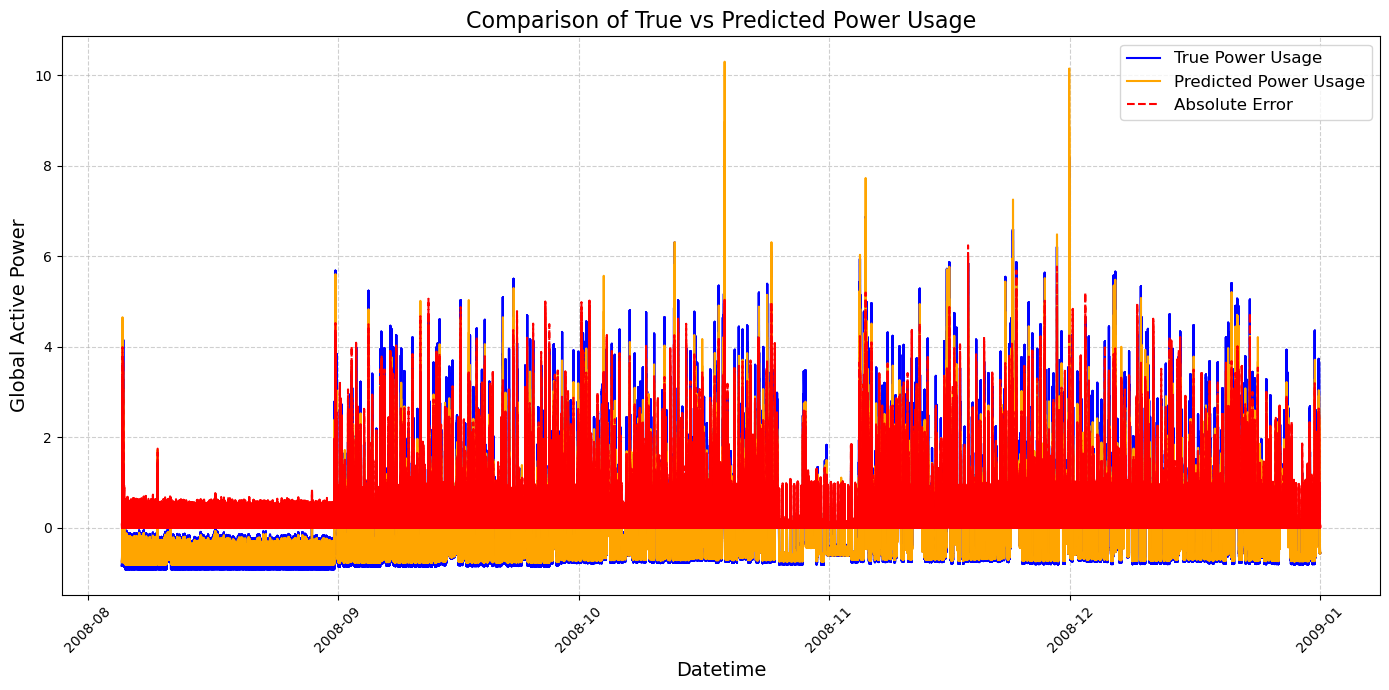

In [11]:
# Predict on the test set
y_pred_test = model.predict(X_test, verbose=0).squeeze()  # Ensure predictions are 1D

absolute_error = np.abs(y_test.squeeze() - y_pred_test)
datetime_test = data['Datetime'][-len(y_test):]
plt.figure(figsize=(14, 7))
plt.plot(datetime_test, y_test.squeeze(), label='True Power Usage', color='blue', linewidth=1.5)
plt.plot(datetime_test, y_pred_test, label='Predicted Power Usage', color='orange', linewidth=1.5)
plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1.5)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()  # Get current handles and labels
by_label = dict(zip(labels, handles))  # Use a dictionary to remove duplicates
plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper right')  # Add legend with unique entries

# Add labels, title, and grid
plt.title('Comparison of True vs Predicted Power Usage', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Global Active Power', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
print(f"Min prediction: {y_pred_test.min()}")
print(f"Max prediction: {y_pred_test.max()}")
print(f"Mean prediction: {y_pred_test.mean()}")

Min prediction: -0.8094000816345215
Max prediction: 10.303091049194336
Mean prediction: -0.11164978891611099
